D2 MultiModal Registration 
200345N

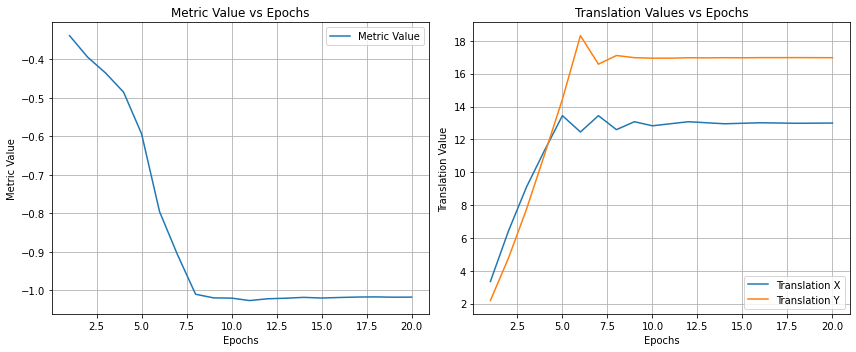

Result = 
 Translation X = 12.994767930652099
 Translation Y = 16.972937327305146
 Iterations    = 20
 Metric value  = -1.0179922078045118


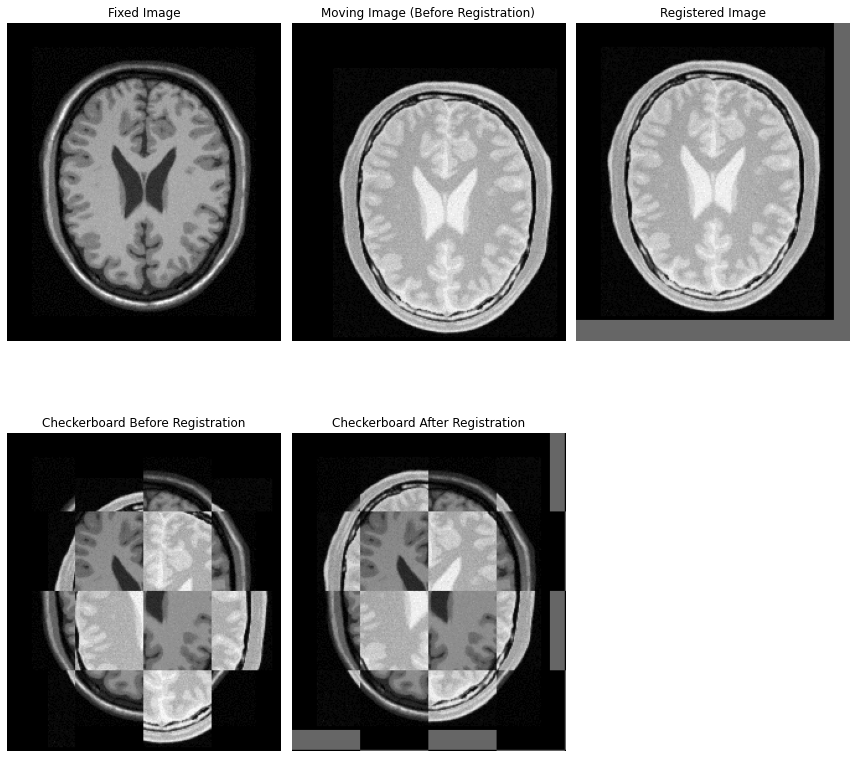

In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np

# Function to perform 2D Translation Registration With Mattes Mutual Information
def perform_multimodal_registration(fixed_image_path, moving_image_path):
    PixelType = itk.ctype("float")

    # Read images
    fixedImage = itk.imread(fixed_image_path, PixelType)
    movingImage = itk.imread(moving_image_path, PixelType)

    Dimension = fixedImage.GetImageDimension()
    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    TransformType = itk.TranslationTransform[itk.D, Dimension]
    initialTransform = TransformType.New()

    metric_values = []
    translation_x_values = []
    translation_y_values = []

    # Callback to track metrics
    def observer():
        currentParameters = optimizer.GetCurrentPosition()
        translation_x = currentParameters.GetElement(0)
        translation_y = currentParameters.GetElement(1)
        metric_value = optimizer.GetValue()

        metric_values.append(metric_value)
        translation_x_values.append(translation_x)
        translation_y_values.append(translation_y)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=20,
    )
    optimizer.AddObserver(itk.IterationEvent(), observer)

    # Use Mattes Mutual Information as the similarity metric
    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    metric.SetNumberOfHistogramBins(50)

    registration = itk.ImageRegistrationMethodv4.New(
        FixedImage=fixedImage,
        MovingImage=movingImage,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform,
    )

    movingInitialTransform = TransformType.New()
    initialParameters = movingInitialTransform.GetParameters()
    initialParameters[0] = 0
    initialParameters[1] = 0
    movingInitialTransform.SetParameters(initialParameters)
    registration.SetMovingInitialTransform(movingInitialTransform)

    identityTransform = TransformType.New()
    identityTransform.SetIdentity()
    registration.SetFixedInitialTransform(identityTransform)

    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])

    # Update registration to compute results
    registration.Update()

    # Plotting metric and translation values against iterations (epochs)
    epochs = list(range(1, len(metric_values) + 1))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metric_values, label="Metric Value")
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Metric Value vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, translation_x_values, label="Translation X")
    plt.plot(epochs, translation_y_values, label="Translation Y")
    plt.xlabel('Epochs')
    plt.ylabel('Translation Value')
    plt.title('Translation Values vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final parameters
    transform = registration.GetTransform()
    finalParameters = transform.GetParameters()
    translationAlongX = finalParameters.GetElement(0)
    translationAlongY = finalParameters.GetElement(1)

    numberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Translation X = " + str(translationAlongX))
    print(" Translation Y = " + str(translationAlongY))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
    outputCompositeTransform = CompositeTransformType.New()
    outputCompositeTransform.AddTransform(movingInitialTransform)
    outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter.New(
        Input=movingImage,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixedImage,
    )
    resampler.SetDefaultPixelValue(100)
    
    resampler.Update()

    OutputPixelType = itk.ctype("unsigned char")
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    caster = itk.CastImageFilter[FixedImageType, OutputImageType].New(Input=resampler)
    caster.Update()

    # Convert ITK images to NumPy arrays for visualization
    def itk_to_numpy(image):
        return itk.GetArrayViewFromImage(image)

    resampled_image_np = itk_to_numpy(caster.GetOutput())
    fixed_image_np = itk_to_numpy(fixedImage)
    moving_image_np = itk_to_numpy(movingImage)

    # Checkerboard before registration
    checkerboard_before = itk.CheckerBoardImageFilter.New(
        Input1=fixedImage, 
        Input2=movingImage,
        CheckerPattern=[4, 4]  # Adjust pattern as necessary
    )
    checkerboard_before.Update()

    # Checkerboard after registration
    checkerboard_after = itk.CheckerBoardImageFilter.New(
        Input1=fixedImage, 
        Input2=resampler.GetOutput(),
        CheckerPattern=[4, 4]
    )
    checkerboard_after.Update()

    # Convert checkerboard to numpy for visualization
    checkerboard_before_np = itk_to_numpy(checkerboard_before.GetOutput())
    checkerboard_after_np = itk_to_numpy(checkerboard_after.GetOutput())

    # Plot the images
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 3, 1)
    plt.imshow(fixed_image_np, cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(moving_image_np, cmap='gray')
    plt.title('Moving Image (Before Registration)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(resampled_image_np, cmap='gray')
    plt.title('Registered Image')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(checkerboard_before_np, cmap='gray')
    plt.title('Checkerboard Before Registration')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(checkerboard_after_np, cmap='gray')
    plt.title('Checkerboard After Registration')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Paths to fixed and moving images
fixed_image_path = 'BrainT1SliceBorder20.png'
moving_image_path = 'BrainProtonDensitySliceShifted13x17y.png'

# Run the function
perform_multimodal_registration(fixed_image_path, moving_image_path)
